# Bilingual dictionary enrichment via graph completion

Current

In [1]:
import logging
import sys
import os

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import json
import re

In [ ]:
import numpy as np

In [2]:
from numpy import vectorize

In [3]:
from collections import Counter
from math import exp

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import networkx as nx
import xml.etree.ElementTree as ET
import requests

In [5]:
import matplotlib.pyplot as plt

## Language codes

In [ ]:
from numpy import na
import pandas as pd
lang_codes = pd.read_csv('./files/language-codes-full_csv.csv', na_values = 0)
lang_codes = lang_codes[['alpha3-b','alpha2']]
lang_codes = lang_codes.dropna()


lang_codes = [{i[0]:i[1] for i in np.array(lang_codes)}, {i[1]:i[0] for i in np.array(lang_codes)}]

with open ('./files/lang_codes.json', 'w') as f:
    json.dump(lang_codes, f)

In [6]:
with open ('./files/lang_codes.json', 'r') as f:
    lang_codes = json.load(f)

def l(lang, mode=3):
    mode = mode % 2
    if len(lang)==2:
        if lang in lang_codes[mode]:
            return lang_codes[mode][lang]
        else:
            return lang
    else:
        return lang
l('tt', 3)

'tat'

## Loading dictionaries

### Git - not relevant

In [2]:
import git

def clone_folder(name='apertium-trunk', target='./data/'):
    repo = git.Repo.clone_from('https://github.com/apertium/'+name+'/', target)
    for i in git.objects.submodule.root.RootModule(repo).list_items(repo):
        git.Repo.clone_from('https://github.com/apertium/'+i.name, './data/'+i.name)
        logging.info(i.name)

clone_folder()

Took 3 hours to clone aprtium-trunk

### PyGithub

** Load user with login and password from secret file **

In [5]:
from github import Github

with open ('secure.json') as f:
    SECRET = json.loads(f.read())

github = Github(SECRET['USER'], SECRET['PASSWORD'])

user = github.get_user('apertium')

In [ ]:
user.get_repos()

** Generator ** : yield all repos that match name pattern

In [6]:
def repo_names(user):
    for repo in user.get_repos():
        if re.match('apertium-[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?', repo.name):
            yield repo.name

Looks like heavy function. But I don't see any improvements yet, except for having certain repo for all bidix copies. But this one above is the most up-to-date. It filters not languages pair repos, it is needed not to look for bidix where it can't be. Function saves a lot of time.

In [18]:
%time w = list(repo_names(user))

Wall time: 26.8 s


** Find bidix **

In [7]:
def bidix_url(repo):
    bidix = repo.name+'.'+repo.name.replace('apertium-','')+'.dix'
    for i in repo.get_dir_contents('/'):
        if re.match('apertium-.*?\.[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?.dix', i.path):
            return i.download_url

In [19]:
%time bidix_url(github.get_repo(user.name+'/'+w[22]))

Wall time: 1.31 s


'https://raw.githubusercontent.com/apertium/apertium-cat-srd/master/apertium-cat-srd.cat-srd.dix'

In [7]:
def bidix_url(repo):
    for i in sorted(repo.get_dir_contents('/'), key = lambda x: (len(x.path), 1000-ord(('   '+x.path)[-3])), reverse=True):
        if re.match('apertium-.*?\.[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?.dix$', i.path):
            return i.download_url
        elif len(i.path) < 23:
            return None

In [27]:
%time bidix_url(github.get_repo(user.name+'/'+w[22]))

Wall time: 709 ms


'https://raw.githubusercontent.com/apertium/apertium-cat-srd/master/apertium-cat-srd.cat-srd.dix'

Speed is ok. 

Check repos for bidixes

In [9]:
def download(user):
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if not bidix:
            print (repo_name)

download(user)

apertium-en-lv
apertium-est-nor
apertium-ita-srd
apertium-ky-en
apertium-lex-tools
apertium-on-github
apertium-ru-cu
apertium-sc-pt
apertium-urd-pan


All these repos do not have bidixes except for the last one. There are two of them. So that's strange.

** XML reading ** : return xml tree object. Read file with request from github and return object

In [8]:
def tree(url):
    response = requests.get(url)
    return ET.fromstring(response.content)

We need to check bidixes, because errors occur.

** Errors **

- eo-bg : strange header section with sdefs    ParseError: mismatched tag: line 10, column 4
- eo-fa : same, looks like < sdef n="n" > should be < sdef n="n"/>
- eo-pl : same
- fin-fra : < !-- \n {{{ Punctuatkion and stuff \n {{{ puncts --> ParseError: not well-formed (invalid token): line 152, column 4
- pl-lv : Possibly, not closed < alphabet > (dictionary) ParseError: mismatched tag: line 296, column 2
- sah-eng : " [< Russ. " in text, this is parsed as tag : ParseError: not well-formed (invalid token): line 339, column 114

In [ ]:
tree('https://raw.githubusercontent.com/apertium/apertium-sah-eng/master/apertium-sah-eng.sah-eng.dix')

Loading all files (even without parsing) takes a lot of time (12 minutes on Windows). So to reduce time in case of gathering files instead of one folder on github we need to reduce number of languages we download.

** Only relevant for certain language pair **

There are **164 ** pairs at this moment

In [38]:
def get_repos_for_pair(user, l1, l2, n=[2]):
    logging.info('Start')
    G = nx.DiGraph()
    lg = (l(l1,3), l(l2,3))
    pair_list = []
    for name in repo_names(user):
        pair_list.append(name)
        w = re.findall('.*?-([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})$', name)[0]
        w = (l(w[0],3), l(w[1],3))
        if w[0] == lg[0] or w[1] == lg[1]: G.add_edge(w[0],w[1])
        elif w[0] == lg[1] or w[1] == lg[0]: G.add_edge(w[1],w[0])
        else:
            G.add_edge(w[0],w[1])
            G.add_edge(w[1],w[0])
    if (lg[0], lg[1]) in G.edges(): G.remove_edge(lg[0], lg[1])
    if (lg[1], lg[0]) in G.edges(): G.remove_edge(lg[1], lg[0])
    logging.info('Graph')
    
    for i in n:
        w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
        v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
        nodes = list((set(w.keys())&set(w.keys()) )| set([lg[0],lg[1]]))
        H = G.subgraph(nodes)
        logging.info('Length: {}\tNodes: {}'.format(i, len(nodes)))
    return G

** Final loading **

In [10]:
def get_repos_for_pair(user, l1, l2, n=[2]):
    logging.info('Start')
    pair_list = []
    G = nx.Graph()
    lg = (l(l1,3), l(l2,3))
    for name in repo_names(user):
        pair_list.append(name)
        w = [l(i,3) for i in re.findall('.*?-([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})$', name)[0]]
        G.add_edge(w[0],w[1])
    logging.info('Built graph')
    
    for i in n:
        w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
        v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
        H = G.subgraph(w.keys())
        H.remove_node(lg[0])
        H2 = G.subgraph(v.keys())
        H2.remove_node(lg[1])
        nodes = set(nx.node_connected_component(H, lg[1])) & set(nx.node_connected_component(H2, lg[0])) | set([lg[0], lg[1]])
        logging.info('Length: {}\tNodes: {}'.format(i, len(nodes)))
        
    i = int(input('Choose max halfway: '))
    w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
    v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
    H = G.subgraph(w.keys())
    H.remove_node(lg[0])
    H2 = G.subgraph(v.keys())
    H2.remove_node(lg[1])
    nodes = set(nx.node_connected_component(H, lg[1])) & set(nx.node_connected_component(H2, lg[0]))| set([lg[0], lg[1]])
    return set(nodes), pair_list

In [11]:
def filter_names(nodes:set, pair_list):
    for repo in pair_list:
        langs = re.findall('apertium-(.*?)-(.*?)$', repo)[0]
        if l(langs[0]) in nodes and l(langs[1]) in nodes:
            yield repo

In [12]:
def download_language_pair_support(user, l1, l2, n=[2]):
    nodes, pair_list = get_repos_for_pair(user, l1, l2, n)
    logging.info('Started loading')
    for repo_name in filter_names(nodes, pair_list):
        url = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if url:
            lang = re.findall('.*?\.([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})\.dix$', url)
            if lang:
                l1, l2 = lang[0][0], lang[0][1]
                try:
                    t = tree(url)
                    yield t
                except:
                    #print(l1, l2)
                    pass
            else:
                print (url)
    logging.info('Finished')

In [46]:
list(download_language_pair_support(user, 'urd','hin', n=[2,3,4]))

2018-05-17 17:39:43,298 | INFO : Start
2018-05-17 17:40:09,223 | INFO : Built graph
2018-05-17 17:40:09,223 | INFO : Length: 2	Nodes: 4
2018-05-17 17:40:09,231 | INFO : Length: 3	Nodes: 4
2018-05-17 17:40:09,234 | INFO : Length: 4	Nodes: 4
Choose max halfway: 4
2018-05-17 17:40:18,115 | INFO : Started loading
2018-05-17 17:40:23,386 | INFO : Finished


[<Element 'dictionary' at 0x0000017B022DD1D8>,
 <Element 'dictionary' at 0x0000017B7EC54548>,
 <Element 'dictionary' at 0x0000017B009780E8>,
 <Element 'dictionary' at 0x0000017B00E77188>]

In [47]:
list(download_language_pair_support(user, 'hin','urd', n=[2,3,4]))

2018-05-17 17:40:27,545 | INFO : Start
2018-05-17 17:41:00,468 | INFO : Built graph
2018-05-17 17:41:00,468 | INFO : Length: 2	Nodes: 4
2018-05-17 17:41:00,468 | INFO : Length: 3	Nodes: 4
2018-05-17 17:41:00,479 | INFO : Length: 4	Nodes: 4
Choose max halfway: 4
2018-05-17 17:41:03,828 | INFO : Started loading
2018-05-17 17:41:08,687 | INFO : Finished


[<Element 'dictionary' at 0x0000017B0083ADB8>,
 <Element 'dictionary' at 0x0000017B047EAEF8>,
 <Element 'dictionary' at 0x0000017B03527D68>,
 <Element 'dictionary' at 0x0000017B05573F48>]

In [15]:
def save_all(user):
    #logging.info('Start')
    for repo_name in repo_names(user):
        url = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if url:
            lang = re.findall('.*?\.([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})\.dix$', url)
            if lang:
                l1, l2 = lang[0][0], lang[0][1]
                try:
                    t = tree(url)
                    yield t, l1, l2
                except:
                    pass
    #logging.info('Finish')

In [20]:
list(save_all(user))[0]

2018-05-17 21:12:40,093 | INFO : Start
2018-05-17 21:32:36,374 | INFO : Finish


(<Element 'dictionary' at 0x0000021592C2CE58>, 'afr', 'nld')

In [30]:
tree('https://raw.githubusercontent.com/apertium/apertium-urd-hin/master/apertium-urd-hin.urd-hin.dix')

<Element 'dictionary' at 0x000001CCDB4114A8>

In [16]:
response = requests.get('https://raw.githubusercontent.com/apertium/apertium-eng-ita/master/apertium-eng-ita.eng-ita.dix')

In [20]:
str(response.content)[:100]

'b\'<?xml version="1.0" encoding="UTF-8"?>\\n<!--\\n\\tDictionary:\\n\\tSections: 1\\n\\tEntries: 24029\\n\\tSd'

In [91]:
def download_all_bidixes(user):
    logging.info('Start')
    if not os.path.exists('./dictionaries/'):
        os.makedirs('./dictionaries/')
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        langs = [l(i) for i in repo_name.split('-')[1:]]
        filename = './dictionaries/'+'-'.join(langs)+'.dix'
        #print (filename)
        if bidix:
            response = requests.get(bidix)
            response.encoding = 'UTF-8'
            #print (response.text)
            with open(filename, 'w', encoding='UTF-8') as f:
                f.write(response.text)
    logging.info('Finish')

In [92]:
download_all_bidixes(user)

2018-05-18 11:22:17,854 | INFO : Start
2018-05-18 11:30:11,682 | INFO : Finish


In [18]:
def get_relevant_languages(l1, l2):
    G = nx.Graph()
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files :
            pair = fl.replace('.dix', '').split('-')
            G.add_edge(pair[0], pair[1])
    pair = [l(l1), l(l2)]
    with open('language_list.csv','w', encoding='utf-8') as f:
        nodes = set()
        for i in range(1,5):
            w = nx.single_source_shortest_path_length(G, pair[0], cutoff=i)
            v = nx.single_source_shortest_path_length(G, pair[1], cutoff=i)
            H = G.subgraph(w.keys())
            H.remove_node(pair[0])
            H2 = G.subgraph(v.keys())
            H2.remove_node(pair[1])
            if pair[1] in H.nodes():
                v = nx.node_connected_component(H, pair[1])
            else:
                v = set()
            if pair[0] in H2.nodes():
                w = nx.node_connected_component(H, pair[1])
            else:
                w = set() 
            nodes2 = v & w | set([pair[0], pair[1]])
            nodes2 = nodes2 - nodes
            for node in nodes2:
                f.write('{}\t{}\n'.format(i*2, node))
            nodes = nodes | nodes2

In [16]:
get_relevant_languages('bel', 'rus')

In [105]:
def check_languages():
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files:
            #print (root+fl)
            try:
                s = ET.parse(root+fl)
            except:
                print ('ERROR :'+fl)

In [106]:
check_languages()

ERROR :epo-bul.dix
ERROR :epo-per.dix
ERROR :epo-pol.dix
ERROR :fin-fra.dix
ERROR :pol-lav.dix
ERROR :sah-eng.dix


In [7]:
def existance(pair, nodes):
    if pair[0] in nodes and pair[1] in nodes:
        return True
    else:
        return False

In [9]:
def load_chosen():
    with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in f.readlines()])
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files:
            pair = fl.replace('.dix','').split('-')
            if existance(pair, languages):
                try:
                    with open (root+fl, 'r', encoding='utf-8') as d:
                        dictionary = d.read().replace('<b/>',' ').replace('<.?g>','')
                        yield ET.fromstring(dictionary), pair[0], pair[1]
                except:
                    print ('ERROR: ', fl)

In [7]:
%time len(list(load_chosen()))

ERROR:  epo-bul.dix
ERROR:  epo-per.dix
ERROR:  epo-pol.dix
ERROR:  fin-fra.dix
ERROR:  pol-lav.dix
ERROR:  sah-eng.dix
Wall time: 3min 47s


269

## Object classes

** Word **

- lemma : lemma
- lang : language
- pos : part of speech

In [25]:
class Word:
    def __init__(self, lemma, lang, s=[]):
        self.lemma = lemma
        self.lang = lang
        self.s = s
    
    def __str__(self):
        return str(self.lang)+'_'+str(self.lemma)+'_'+str('-'.join(self.s))
    
    __repr__ = __str__
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and self.s == other.s
    
    def __hash__(self):
        return hash(str(self))

## Parsing

### Bidix parsing

In [11]:
%time T = tree('https://raw.githubusercontent.com/apertium/apertium-eng-ita/master/apertium-eng-ita.eng-ita.dix')

Wall time: 921 ms


In [11]:
def one_word(word, lang):
    s = word.findall('.//s')
    s = [i.attrib['n'] for i in s]
    return Word(word.text, lang, s)

In [12]:
def parse_bidix (tree, l1, l2):
    tree = tree.find('section')
    if not tree:
        print (l1, l2)
    else:
        for e in tree:
            if 'n' in e.attrib:
                side = e.attrib['n']
            else:
                side = None
            p = e.find('p')
            if p:
                yield one_word(p.find('l'), l1), one_word(p.find('r'), l2), side
            else:
                try:
                    i = e.find('i')
                    yield one_word(i, l1), one_word(i, l2), side
                except:
                    pass

In [147]:
% time len(list(parse_bidix (T, 'bel','rus')))

Wall time: 882 ms


48880

In [13]:
def add_bidix(G, T, l1, l2):
    for word1, word2, side in parse_bidix (T, l1, l2):
        if side == None:
            G.add_edge(word1, word2)
            G.add_edge(word2, word1)
        elif side == 'LR':
            G.add_edge(word1, word2)
        elif side == 'RL':
            G.add_edgr(word2, word1)
        else:
            print (side)

In [145]:
G = nx.DiGraph()
%time add_bidix(G, T, 'bel', 'rus')

Wall time: 1.21 s


In [132]:
len(G.nodes())

89496

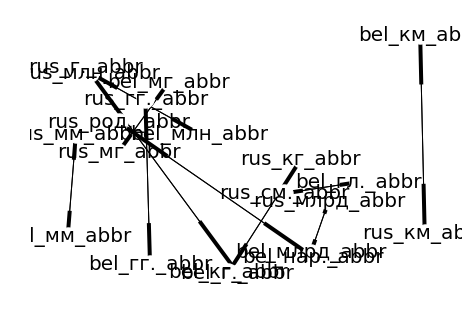

In [144]:
nx.draw_random(G, with_labels = True, font_size = 20, node_color = 'white')
plt.show()

In [14]:
G = nx.DiGraph()
logging.info('Start')
for T, l1, l2 in load_chosen():
    add_bidix(G, T, l1, l2)
    #try:
    #    add_bidix(G, T, l1, l2)
    #except:
    #    logging.info('not added {}-{}'.format(l1,l2))
    #add_bidix(G, T, l1, l2)
logging.info('Finish')

2018-05-20 14:31:55,751 | INFO : Start
ERROR:  epo-bul.dix
ERROR:  epo-per.dix
ERROR:  epo-pol.dix
ERROR:  fin-fra.dix
lit lav
ERROR:  pol-lav.dix
ERROR:  sah-eng.dix
2018-05-20 14:35:14,629 | INFO : Finish


In [15]:
len(G.nodes())

2074265

In [16]:
len(G.edges())

4155096

In [12]:
import pickle as pkl
with open('graph.pkl','wb') as f:
    pkl.dump(G, f)

In [13]:
w1 = Word('картошка','rus',['n', 'f','nn'])
w2 = Word('бульба','bel',['n', 'f','nn'])

In [20]:
for i in G.nodes():
    if 'бульба' in str(i):
        print (i)

bel_бульбапасадачны_adj
bel_бульбаўборачны_adj
bel_бульбавод_n-m-aa
bel_бульбамыйка_n-f-nn
bel_бульба_n-f-nn
bel_бульбаводства_n-nt-nn
bel_бульбасховішча_n-nt-nn
bel_бульбасаджалка_n-f-nn
bel_бульбакапалка_n-f-nn
epo_бульба_n
ukr_бульба_n-f-nn


In [16]:
for i in range(2,10):
    %time w = list(nx.all_simple_paths(G, w1,w2, cutoff=i))
    print (i, len(w))

Wall time: 0 ns
2 1
Wall time: 0 ns
3 5
Wall time: 997 µs
4 5
Wall time: 2 ms
5 7
Wall time: 7.99 ms
6 7
Wall time: 29 ms
7 7
Wall time: 138 ms
8 7
Wall time: 901 ms
9 9


In [18]:
list(nx.all_simple_paths(G, w1,w2, cutoff=4))

[[rus_картошка_n-f-nn, bel_бульба_n-f-nn],
 [rus_картошка_n-f-nn, kaz_картоп_n, rus_картофель_n-m-nn, bel_бульба_n-f-nn],
 [rus_картошка_n-f-nn,
  pol_ziemniak_n-mi,
  rus_картофель_n-m-nn,
  bel_бульба_n-f-nn],
 [rus_картошка_n-f-nn,
  ukr_бульба_n-f-nn,
  rus_картофель_n-m-nn,
  bel_бульба_n-f-nn],
 [rus_картошка_n-f-nn,
  ukr_картопля_n-f-nn,
  rus_картофель_n-m-nn,
  bel_бульба_n-f-nn]]

In [24]:
class SetWithFilter(set):
    def lemma(self, value):
        return set(i for i in self if i.lemma == value)
    def pos(self, value):
        return set(i for i in self if i.pos == value)
    def lang(self, value):
        return set(i for i in self if i.lang == value)
    def notlang(self, value):
        return set(i for i in self if i.lang != value)

In [22]:
def dictionaries(G, l1,l2):
    l1 = l(l1)
    l2 = l(l2)
    d_l1 = SetWithFilter()
    d_l2 = SetWithFilter()
    for i in G.nodes():
        if i.lang == l1:
            d_l1.add(i)
        elif i.lang == l2:
            d_l2.add(i)
    return d_l1, d_l2

In [140]:
d_l1, d_l2 = dictionaries(G, 'bel','rus')

In [141]:
len(d_l1)

49814

In [142]:
len(d_l2)

90062

In [31]:
d_l2.lemma('что')

{rus_что_cnjcoo,
 rus_что_cnjsub,
 rus_что_itg,
 rus_что_n,
 rus_что_prn,
 rus_что_prn-itg,
 rus_что_prn-itg-nt,
 rus_что_prn-itg-nt-sg}

In [32]:
d_l2.lemma('ты')

{rus_ты_n,
 rus_ты_prn,
 rus_ты_prn-pers,
 rus_ты_prn-pers-p2-mf-sg,
 rus_ты_prn-pers-p2-mf-sg-gen}

In [143]:
d_l2.lemma('порошок')

{rus_порошок_n, rus_порошок_n-m-nn}

In [ ]:
%time length = nx.all_pairs_shortest_path_length(G)

In [38]:
%time s = SetWithFilter(list(nx.descendants(G, w2)))
%time len(s.lang('rus'))

Wall time: 10 s
Wall time: 339 ms


32684

In [39]:
%time s = SetWithFilter(list(nx.descendants(G, w1)))
%time len(s.lang('bel'))

Wall time: 9.54 s
Wall time: 341 ms


11961

In [76]:
len(G.nodes())

1513514

In [77]:
len(G.edges())

2844148

In [57]:
w2 in s

True

In [62]:
def find (G, word, l2, cutoff):
    s = SetWithFilter(list(nx.descendants(G, word)))
    s = s.lang(l2)
    for translation in s:
        t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
        if len(t) > 0:
            print(translation, len(t))

In [64]:
%time find (G, w1, 'bel', 6)

bel_бульбіна_n-f-nn 12
bel_яблык_n-m-nn 7
bel_бульба_n-f-nn 7
bel_бутэлька_n-f-nn 2
bel_клубень_n-m-nn 5
Wall time: 1min 15s


In [130]:
def find (G, word, l2, cutoff):
    logging.info('Start')
    s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
    print ('all: ', str(len(s)))
    s = s.lang(l2)
    print ('filtered: ', str(len(s)))
    logging.info('Start counting')
    for translation in s:
        t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
        if len(t) > 0:
            print(translation, len(t))
            pass
    logging.info('Finish counting')

In [133]:
%time find (G, w1, 'bel', 6)

2018-05-19 11:52:53,812 | INFO : Start
all:  515
filtered:  5
2018-05-19 11:52:53,824 | INFO : Start counting
bel_бутэлька_n-f-nn 2
bel_яблык_n-m-nn 7
bel_клубень_n-m-nn 5
bel_бульба_n-f-nn 7
bel_бульбіна_n-f-nn 12
2018-05-19 11:52:53,868 | INFO : Finish counting
Wall time: 58.9 ms


In [134]:
%time find (G, w1, 'bel', 8)

2018-05-19 11:52:55,645 | INFO : Start
all:  7307
filtered:  48
2018-05-19 11:52:55,783 | INFO : Start counting
bel_яблык_n-m-nn 58
bel_наяўнасць_n-f-nn 4
bel_бульба_n-f-nn 7
bel_палажэнне_n-nt-nn 4
bel_від_n-m-nn 4
bel_трунак_n-m-nn 2
bel_дзюрка_n-f-nn 2
bel_прэтэнцыёзнасць_n-f-nn 4
bel_становішча_n-nt-nn 4
bel_банк_n-m-nn 4
bel_багацце_n-nt-nn 4
bel_плод_n-m-nn 5
bel_гняздоўе_n-nt-nn 2
bel_званне_n-nt-nn 4
bel_сасна_n-f-nn 6
bel_яблыня_n-f-nn 39
bel_клубень_n-m-nn 7
bel_габлюшка_n-f-nn 4
bel_ананас_n-m-nn 2
bel_прыбіральня_n-f-nn 2
bel_банка_n-f-nn 4
bel_віно_n-nt-nn 2
bel_хвоя_n-f-nn 6
bel_статус_n-m-nn 12
bel_паўлітроўка_n-f-nn 2
bel_порт¹_n-m-nn 2
bel_узровень_n-m-nn 4
bel_садавіна_n-f-nn 10
bel_настрой_n-m-nn 4
bel_гняздо_n-nt-nn 2
bel_плён_n-m-nn 5
bel_стружка_n-f-nn 4
bel_бутэлька_n-f-nn 20
bel_футшток_n-m-nn 4
bel_штат¹_n-m-nn 16
bel_месцазнаходжанне_n-nt-nn 4
bel_шпонка_n-f-nn 2
bel_напітак_n-m-nn 2
bel_туалет¹_n-m-nn 2
bel_бульбіна_n-f-nn 18
bel_лодка_n-f-nn 2
bel_спірт_n-m-

In [136]:
word = Word('порошок', 'rus', ['n'])
%time find (G, word, 'bel', 6)

2018-05-19 11:53:19,292 | INFO : Start
all:  1187
filtered:  8
2018-05-19 11:53:19,317 | INFO : Start counting
bel_талакно_n-nt-nn 2
bel_парашок¹_n-m-nn 2
bel_пылаўлоўнік_n-m-nn 1
bel_парашок²_n-m-nn 2
bel_пыл_n-m-nn 2
bel_пудра_n-f-nn 1
bel_адчуванне_n-nt-nn 1
bel_манна_n-f-nn 2
2018-05-19 11:53:19,395 | INFO : Finish counting
Wall time: 108 ms


In [38]:
def check (G, word, l2, cutoff):
    print(word, end='\t')
    s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
    print ('all: ', str(len(s)), end='\t')
    s = s.lang(l2)
    print ('filtered: ', str(len(s)))
    for translation in s:
        t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
        if len(t) > 0:
            #print(translation, len(t))
            pass

In [99]:
for i in range(1, 9):
    %time check (G, w1, 'bel', i)

1	all:  7	filtered:  1
Wall time: 0 ns
2	all:  15	filtered:  1
Wall time: 0 ns
3	all:  35	filtered:  3
Wall time: 1 ms
4	all:  71	filtered:  3
Wall time: 3 ms
5	all:  184	filtered:  3
Wall time: 10 ms
6	all:  515	filtered:  5
Wall time: 45 ms
7	all:  2163	filtered:  14
Wall time: 364 ms
8	all:  7307	filtered:  48
Wall time: 6.45 s


In [138]:
def lemma_search (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    print (lemmas)
    for word in lemmas:
        print(word, end='\t')
        s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        print ('all: ', str(len(s)), end='\t')
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        for translation in s:
            t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            if len(t) > 0:
                #print(translation, len(t))
                pass

In [30]:
def lemma_search (G, lemma, d_l1, l2, cutoff):
    lemmas = d_l1.lemma(lemma)
    print (lemmas)
    results = {str(word):{} for word in lemmas}
    for word in lemmas:
        print(word, end='\t')
        s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
        print ('all: ', str(len(s)), end='\t')
        s = s.lang(l2)
        print ('filtered: ', str(len(s)))
        for translation in s:
            t = list(nx.all_simple_paths(G, word, translation, cutoff=cutoff))
            t = [len(i) for i in t]
            t = Counter(t)
            coef = 0
            for i in t:
                coef += exp(-t[i])
            results[str(word)][str(translation)] = coef
    return results

In [160]:
%time results = lemma_search (G, 'картошка', d_l2, 'bel', 7)

{rus_картошка_n-f-nn}
rus_картошка_n-f-nn	all:  2163	filtered:  14
Wall time: 427 ms


In [163]:
for i in results:
    for j in sorted(results[i], key=results[i].get, reverse=True):
        print (j, results[i][j])

bel_бульбіна_n-f-nn 0.7990218447089196
bel_бульба_n-f-nn 0.5215303632967893
bel_клубень_n-m-nn 0.5215303632967891
bel_бутэлька_n-f-nn 0.13781403541327905
bel_сасна_n-f-nn 0.1353352832366127
bel_габлюшка_n-f-nn 0.1353352832366127
bel_шпонка_n-f-nn 0.1353352832366127
bel_хвоя_n-f-nn 0.1353352832366127
bel_стружка_n-f-nn 0.1353352832366127
bel_садавіна_n-f-nn 0.006737946999085467
bel_плён_n-m-nn 0.006737946999085467
bel_плод_n-m-nn 0.006737946999085467
bel_яблыня_n-f-nn 0.0024787521766663585
bel_яблык_n-m-nn 0.0012473445934570282


In [19]:
def print_results(results):
    for i in results:
        print ('\n\t\t', i)
        for j in sorted(results[i], key=results[i].get, reverse=True)[:7]:
            print (j, results[i][j])

### RUS-FRA

In [20]:
get_relevant_languages('rus', 'fra')

In [17]:
G = nx.DiGraph()
logging.info('Start')
for T, l1, l2 in load_chosen():
    add_bidix(G, T, l1, l2)
logging.info('Finish')

2018-05-20 11:26:48,971 | INFO : Start
ERROR:  epo-bul.dix
ERROR:  epo-per.dix
ERROR:  epo-pol.dix
ERROR:  fin-fra.dix
lit lav
ERROR:  pol-lav.dix
ERROR:  sah-eng.dix
2018-05-20 11:29:36,417 | INFO : Finish


In [25]:
import pickle as pkl
with open('graph.pkl','wb') as f:
    pkl.dump(G, f)

In [8]:
import pickle as pkl
with open('graph.pkl','rb') as f:
    G = pkl.load(f)

In [26]:
d_l1, d_l2 = dictionaries(G, 'rus','fra')

In [27]:
def check_lemma (G, lemma, d_l1, l2):
    lemmas = d_l1.lemma(lemma)
    print (lemmas)
    results = {str(word):{} for word in lemmas}
    for word in lemmas:
        print (word)
        for cutoff in range(1, 8):
            print (cutoff, end='\t')
            s = SetWithFilter(nx.single_source_shortest_path_length(G, word, cutoff=cutoff))
            print ('all: ', str(len(s)), end='\t')
            s = s.lang(l2)
            print ('filtered: ', str(len(s)))
            if len(s)>150:
                break

In [22]:
check_lemma (G, 'вопрос', d_l1, 'fra')

{rus_вопрос_n-m-nn, rus_вопрос_n-m, rus_вопрос_n}
rus_вопрос_n-m-nn
1	all:  21	filtered:  0
2	all:  192	filtered:  1
3	all:  1949	filtered:  26
4	all:  9335	filtered:  166
5	all:  66094	filtered:  1317
6	all:  162835	filtered:  3933
7	all:  305486	filtered:  7659
rus_вопрос_n-m
1	all:  2	filtered:  0
2	all:  3	filtered:  0
3	all:  8	filtered:  0
4	all:  292	filtered:  3
5	all:  1255	filtered:  19
6	all:  20074	filtered:  413
7	all:  53489	filtered:  1223
rus_вопрос_n
1	all:  2	filtered:  0
2	all:  20	filtered:  3
3	all:  144	filtered:  4
4	all:  654	filtered:  16
5	all:  6182	filtered:  114
6	all:  27514	filtered:  534
7	all:  126529	filtered:  2730


In [26]:
%time print_results(lemma_search (G, 'вопрос', d_l1, 'fra', 4))

{rus_вопрос_n-m-nn, rus_вопрос_n-m, rus_вопрос_n}
rus_вопрос_n-m-nn	all:  9335	filtered:  166
rus_вопрос_n-m	all:  292	filtered:  3
rus_вопрос_n	all:  654	filtered:  16

		 rus_вопрос_n-m-nn
fra_valise_n-f 0.7357588823428847
fra_humeur_n-f 0.7357588823428847
fra_occasion_n-f 0.7357588823428847
fra_qualité_n-f 0.7357588823428847
fra_etat_n-m 0.7357588823428847
fra_obligation_n-f 0.7357588823428847
fra_position_n-f 0.503214724408055

		 rus_вопрос_n-m
fra_question_n-f 0.36787944117144233
fra_matière_n-f 0.36787944117144233
fra_sujet_n-m 0.049787068367863944

		 rus_вопрос_n
fra_question_n-f 0.7540745212316189
fra_demande_n-f 0.7357588823428847
fra_interrogation_n-f 0.36787944117144233
fra_interrogatoire_n-m 0.36787944117144233
fra_sujet_n-m 0.36787944117144233
fra_requête_n-f 0.36787944117144233
fra_consultation_n-f 0.36787944117144233
Wall time: 6.58 s


In [63]:
%time print_results(lemma_search (G, 'собака', d_l1, 'fra', 4))

{rus_собака_n-f, rus_собака_n, rus_собака_n-f-aa}
rus_собака_n-f	all:  252	filtered:  3
rus_собака_n	all:  800	filtered:  20
rus_собака_n-f-aa	all:  2499	filtered:  47

		 rus_собака_n-f
fra_chien_n-GD 0.7357588823428847
fra_chien_n 0.3861950800601765
fra_chien_n-m 0.36787944117144233

		 rus_собака_n
fra_chien_n 0.5032208686204084
fra_chien_n-m 0.503214724408055
fra_colimaçon_n-m 0.4176665095393063
fra_chien_n-GD 0.4176665095393063
fra_limaçon_n-m 0.3861950800601765
fra_singe_n-m 0.36787944117144233
fra_goal_n-m 0.36787944117144233

		 rus_собака_n-f-aa
fra_vigile_n-m 0.503214724408055
fra_surveillant_n-f 0.503214724408055
fra_surveillant_n-m 0.503214724408055
fra_chien_n-GD 0.4180019721672088
fra_chien_n 0.3703581933481431
fra_chien_n-m 0.36879132313699686
fra_haillon_n-m 0.36787944117144233
Wall time: 618 ms


In [94]:
%time print_results(lemma_search (G, 'поле', d_l1, 'fra', 3))

{rus_поле_n, rus_поле_n-nt-nn, rus_поле_n-nt-nn-pl, rus_поле_n-nt}
rus_поле_n	all:  299	filtered:  7
rus_поле_n-nt-nn	all:  831	filtered:  12
rus_поле_n-nt-nn-pl	all:  3	filtered:  0
rus_поле_n-nt	all:  148	filtered:  2

		 rus_поле_n
fra_camp_n-m 0.7357588823428847
fra_champ_n-m 0.7357588823428847
fra_marge_n-m 0.7357588823428847
fra_plantation_n-f 0.7357588823428847
fra_terrain_n-m 0.36787944117144233
fra_berge_n-f 0.1353352832366127
fra_rive_n-f 0.1353352832366127

		 rus_поле_n-nt-nn
fra_camp_n-m 0.3746173881705278
fra_champ_n-m 0.3746173881705278
fra_camp_n 0.36787944117144233
fra_terrain_n-m 0.36787944117144233
fra_patinoire_n-f 0.36787944117144233
fra_cadre_n 0.36787944117144233
fra_champ_n 0.36787944117144233

		 rus_поле_n-nt-nn-pl

		 rus_поле_n-nt
fra_champ_n-m 0.36787944117144233
fra_camp_n-m 0.36787944117144233
Wall time: 3.55 s


In [36]:
1 - len(node_set)/len(G.nodes())

0.1364602245881461

In [54]:
check_lemma (G, 'partie', d_l2, 'rus')

{fra_partie_n-f, fra_partie_n, fra_partie_n-m}
fra_partie_n-f
1	all:  14	filtered:  0
2	all:  192	filtered:  14
3	all:  1039	filtered:  28
4	all:  16390	filtered:  225
fra_partie_n
1	all:  2	filtered:  0
2	all:  5	filtered:  0
3	all:  7	filtered:  0
4	all:  12	filtered:  0
5	all:  31	filtered:  0
6	all:  227	filtered:  15
7	all:  1628	filtered:  31
fra_partie_n-m
1	all:  3	filtered:  0
2	all:  21	filtered:  0
3	all:  67	filtered:  0
4	all:  643	filtered:  4
5	all:  2708	filtered:  62
6	all:  28491	filtered:  264


In [96]:
%time print_results(lemma_search (G, 'serpent', d_l2, 'rus', 4))

{fra_serpent_n-m}
fra_serpent_n-m	all:  767	filtered:  10

		 fra_serpent_n-m
rus_змей_n 0.5035501870359576
rus_змея_n 0.5035501870359576
rus_змейка_n-f-nn 0.3861950800601765
rus_змея_n-f-aa 0.37461750070570254
rus_уж_n 0.3746173881705278
rus_змей_n-m-aa 0.3703581933481087
rus_гадюка_n-f-aa 0.36787944117144233
Wall time: 6.02 s


In [78]:
check_lemma (G, 'chien', d_l2, 'rus')

{fra_chien_n-GD, fra_chien_n, fra_chien_n-m}
fra_chien_n-GD
1	all:  2	filtered:  0
2	all:  111	filtered:  1
3	all:  251	filtered:  9
4	all:  2297	filtered:  30
5	all:  6282	filtered:  208
fra_chien_n
1	all:  11	filtered:  0
2	all:  136	filtered:  7
3	all:  503	filtered:  16
4	all:  2748	filtered:  65
5	all:  12007	filtered:  244
fra_chien_n-m
1	all:  5	filtered:  0
2	all:  21	filtered:  1
3	all:  182	filtered:  4
4	all:  614	filtered:  17
5	all:  3905	filtered:  70
6	all:  16015	filtered:  357


In [39]:
%time print_results(lemma_search (G, 'chien', d_l2, 'rus', 4))

{fra_chien_n-GD, fra_chien_n-m, fra_chien_n}
fra_chien_n-GD	all:  2008	filtered:  27
fra_chien_n-m	all:  378	filtered:  13
fra_chien_n	all:  2114	filtered:  28

		 fra_chien_n-GD
rus_собака_n-f 0.7357588823428847
rus_собачонок_n-m-aa 0.7357588823428847
rus_пёс_n-mi 0.7357588823428847
rus_дворняжка_n-f-aa 0.503214724408055
rus_собака_n-f-aa 0.4180019721672088
rus_пёс_n 0.4176665095393063
rus_собака_n 0.4176665095393063

		 fra_chien_n-m
rus_пёс_n 0.503214724408055
rus_собака_n 0.503214724408055
rus_собака_n-f-aa 0.36879132313699686
rus_собачонок_n-m-aa 0.36787944117144233
rus_дворняжка_n-f-aa 0.36787944117144233
rus_охотничья собака_n 0.36787944117144233
rus_триггер_n 0.36787944117144233

		 fra_chien_n
rus_пёс_n 0.5032208686204084
rus_собака_n 0.5032208686204084
rus_цепной пёс_n 0.4176665095393063
rus_охотничья собака_n 0.4176665095393063
rus_цепная собака_n 0.4176665095393063
rus_овчарка_n 0.4176665095393063
rus_собака_n-f 0.3861950800601765
Wall time: 1.12 s


In [38]:
G.edges(Word('застеклённая дверь','rus', ['n']))

[(rus_застеклённая дверь_n, epo_fenestropordo_n)]

In [95]:
for node in G.nodes():
    if len(node.s) > 6:
        print (node)

ben_prpers_prn-p3-infml-aa-mf-sg-gen
cym_rhywun_prn-tn-m-sg-tn-m-sg
kaz_сіз_prn-pers-p2-sg-frm-gen-subst-nom
eng_you're_prn-subj-p2-mf-sp-vbser-pres
sco_ye're_prn-subj-p2-mf-sp-vbser-pres
fin_sama_adj-pos-sg-ess-n-sg-ess
hbs_na_pr-acc-prn-pers-clt-p3-m-sg-acc
hin_वह_prn-dem-p3-mf-sg-dst-nom
hin_वह_prn-dem-p3-mf-pl-dst-nom
ita_Milà_np-cog-cog-cog-cog-mf-sp


In [28]:
G.edges(Word('cokolwiek','pol', ['prn']))

[(pol_cokolwiek_prn, rus_что-нибудь_prn),
 (pol_cokolwiek_prn, rus_какой бы ни_prn),
 (pol_cokolwiek_prn, rus_любой_prn),
 (pol_cokolwiek_prn, rus_что бы ни_prn),
 (pol_cokolwiek_prn, rus_что угодно_prn),
 (pol_cokolwiek_prn, rus_что-либо_prn)]

In [ ]:
s = 'какой'
for node in G.nodes():
    if node.lemma:
        if s in node.lemma:
            print (node)

### Word tags

In [95]:
d = {}
for i in d_l1:
    if i.lemma not in d:
        d[i.lemma] = set()
    d[i.lemma].add('_'.join(i.s))

In [100]:
a = [' | '.join(list(sorted(d[i]))) for i in d if len(d[i])>1]
print(len(a)/len(d_l1))
a = Counter(a)

0.17975050961623681


In [91]:
for i in sorted(a, key=a.get, reverse=True)[:20]:
    print (i, a[i])

n | n_m_nn 2841
n | n_f_nn 2549
n | n_m_aa 1178
adj_sint | n 1149
n | n_nt_nn 921
adj | adj_sint | n 586
adj | adj_sint 382
n | vblex_perf | vblex_perf_tv 353
n | vblex_perf_tv 344
n | n_f | n_f_nn 287
n | n_m | n_m_nn 265
vblex_perf | vblex_perf_tv 251
adv | n 236
n | vblex_impf 218
n | vblex_impf_tv 210
n | n_f_aa 197
n | vblex_impf | vblex_impf_tv 190
adj | n 183
vblex_impf | vblex_impf_tv 154
n_m_aa | n_m_nn 132


In [104]:
d = {}
for i in d_l2:
    if i.lemma not in d:
        d[i.lemma] = set()
    d[i.lemma].add('_'.join(i.s))

In [110]:
c = [d[i] for i in d if 'n' in d[i]]

In [115]:
len(c)/len([i.lemma for i in d_l2 if 'n' in i.s])

0.2980614543114543

In [102]:
a = [' | '.join(list(sorted(d[i]))) for i in d if len(d[i])>1]
print(len(a)/len(d_l2))
a = Counter(a)
for i in sorted(a, key=a.get, reverse=True)[:20]:
    print (i, a[i])

0.17001942380570761
n | n_f 2496
n | n_m 1651
np | np_cog_mf_sp 811
adj | n 583
adj | adj_mf 386
np | np_ant | np_ant_m_sg 330
np | np_cog 325
np | np_loc_f 311
np | np_ant | np_ant_f_sg 288
adj | n_m 257
np | np_ant 230
adj | adj_GD | adj_f | adj_m 193
adj | n | n_m 172
n_f | n_m 166
np | np_ant_m_sg 118
n | n_mf 117
np_ant_f_sg | np_cog_mf_sp 98
np | np_cog | np_cog_mf_sp 84
adj | n | n_mf 83
num | num_mf_sp 83
